# [IAPR][iapr]: Project


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 07.05.2021  
**Due date:** 03.06.2021 (23h59)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## Rank classification
### Import data

In [1]:
import pickle
import numpy as np
import os

save_folder = "train_set/"

ranks_images = np.load(save_folder+'ranks_im.npy')
with open(save_folder+"ranks_label.txt", "rb") as fp:   # Unpickling
    ranks_label_op = pickle.load(fp)

In [2]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [3]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_MNIST_folder = os.path.join(os.pardir, 'project/train_set')

train_images_path = os.path.join(data_MNIST_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_MNIST_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_MNIST_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_MNIST_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

In [4]:
train_images_flattened = train_images.reshape(train_images.shape[0], -1) # Reshape to a 784 - dimensional image
test_images_flattened = test_images.reshape(test_images.shape[0], -1) # Reshape to a 784 - dimensional image

### Balance classes

The classes are unbalanced, we have about 6000 samples for each digit but dozens only for J,Q and K. We also need to map the labels J, Q and K to int, i.e 10, 11, 12 respectively.

In [5]:
map_jqk = {'J': 10, 'Q': 11, 'K': 12}

for i in range(len(ranks_label_op)):
    ranks_label_op[i] = map_jqk[ranks_label_op[i]]
        
# Convert labels to numpy array
ranks_label_np = np.asarray(ranks_label_op).astype(np.int64)

#### Generate samples for J

In [6]:
j_mask = (ranks_label_np == 10)
j_images = ranks_images[j_mask]

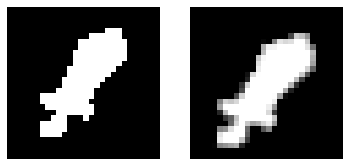

In [7]:
from skimage import transform as tf

# Try some transformation
tform = tf.SimilarityTransform(scale=0.95, rotation= -np.deg2rad(3))

fig, ax = plt.subplots(1, 2, figsize = (6, 6))

ax[0].imshow(j_images[3,:].reshape(image_shape), cmap='gray')
ax[0].axis('off')

ax[1].imshow(tf.warp(j_images[3,:].reshape(image_shape), tform), cmap='gray')
ax[1].axis('off')

plt.show()

We will generate around 7000 J samples by applying tranformations to the 21 images of J we have. We need around 6000 for training and 1000 for testing to match the class distribution in MNIST.

In [8]:
from random import triangular, uniform

def gen_samples(images, image_label, scale_low=0.9, scale_high=1.1,
                rot=np.deg2rad(3), num_samples=334):

    gen = []

    for num in range(images.shape[0]):

        im = images[num, :]

        gen.append(im)

        # Generate num_samples samples for each image
        for i in range(num_samples):
           
            tform = tf.SimilarityTransform(scale=uniform(scale_low, scale_high), rotation=uniform(-rot, rot))

            gen.append(tf.warp(im.reshape(image_shape), tform).flatten())

    # Combine images + labels in one array
    gen = np.asarray(gen)
    gen_array = np.empty((gen.shape[0], gen.shape[1]+1))
    gen_array[:,:-1] = gen
    gen_array[:, -1] = np.ones((gen.shape[0],)) * image_label

    return gen_array

In [9]:
j_gen = gen_samples(j_images, 10)

In [10]:
j_gen.shape

(7035, 785)

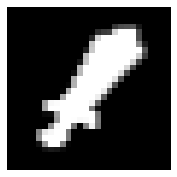

In [11]:
# Look at one image
fig, ax = plt.subplots(1, 1, figsize = (3, 3))

ax.imshow(j_gen[3630,:-1].reshape(image_shape), cmap='gray')
ax.axis('off')

plt.show()

#### Generate samples for Q

In [12]:
q_mask = (ranks_label_np == 11)
q_images = ranks_images[q_mask]

In [13]:
q_images.shape

(22, 784)

In [14]:
q_gen = gen_samples(q_images, 11)

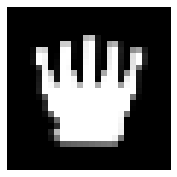

In [15]:
# Look at one image
fig, ax = plt.subplots(1, 1, figsize = (3, 3))

ax.imshow(q_gen[6000,:-1].reshape(image_shape), cmap='gray')
ax.axis('off')

plt.show()

#### Generate samples for K

In [16]:
k_mask = (ranks_label_np == 12)
k_images = ranks_images[k_mask]

In [17]:
k_images.shape

(26, 784)

In [18]:
k_gen = gen_samples(k_images, 12, scale_low=0.97, scale_high=1.03, rot=np.deg2rad(2))

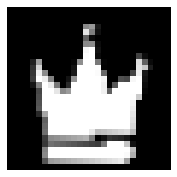

In [19]:
# Look at one image
fig, ax = plt.subplots(1, 1, figsize = (3, 3))

ax.imshow(k_gen[2679,:-1].reshape(image_shape), cmap='gray')
ax.axis('off')

plt.show()

#### Merge generated data

In [20]:
merged_gen = np.append(j_gen, q_gen, axis=0)
merged_gen = np.append(merged_gen, k_gen, axis=0)
np.random.shuffle(merged_gen)

In [21]:
merged_gen.shape

(23115, 785)

We will also the merge the generated data to MNIST data. First we append the labels to the images in MNIST.

In [22]:
train_images_flattened.shape

(60000, 784)

In [23]:
train_images_labels = np.concatenate((train_images_flattened, np.expand_dims(train_labels, axis=1)), axis=1)
test_images_labels = np.concatenate((test_images_flattened, np.expand_dims(test_labels, axis=1)), axis=1)

In [24]:
train_images_labels.shape

(60000, 785)

Now we merge it to the generated data. We add 3000 generated samples (approx 1000 for each class) to the test data and the rest to the train data.

In [25]:
# Test data
test_merged = np.append(merged_gen[:3000], test_images_labels, axis=0)
np.random.shuffle(test_merged)

# Train data
train_merged = np.append(merged_gen[3000:], train_images_labels, axis=0)
np.random.shuffle(train_merged)

We save the train and test data for later use.

In [26]:
np.save(save_folder+'test_ranks.npy', test_merged)
np.save(save_folder+'train_ranks.npy', train_merged)

### Classification

We need to split the images and the labels again.

In [27]:
train_im = train_merged[:,:-1]
train_labels = train_merged[:,-1].astype(np.int64)

test_im = test_merged[:,:-1]
test_labels = test_merged[:,-1].astype(np.int64)

We train a simple MLP to perform classification

In [28]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # to scale the values of the pixels
scaler.fit(train_im)  

train_images_scaled = scaler.transform(train_im)  # Scale train_images
test_images_scaled = scaler.transform(test_im) # Scale test_images

hidden_units = 100

clf = MLPClassifier(hidden_layer_sizes = (hidden_units,), random_state=42).fit(train_images_scaled, train_labels)

clf.score(test_images_scaled, test_labels)

0.9606923076923077

---
### Suite classification
#### Import data

In [29]:
# Open suite files
suites_images = np.load(save_folder+'suites_im.npy')
with open(save_folder+"suites_label.txt", "rb") as fp2:   # Unpickling
    suites_label_op = pickle.load(fp2)

In [30]:
map_hcds = {'H': 0, 'C': 1, 'D': 2, 'S': 3}

for i in range(len(suites_label_op)):
    suites_label_op[i] = map_hcds[suites_label_op[i]]
        
# Convert labels to numpy array
suites_label_op = np.asarray(suites_label_op).astype(np.int64)

#### Generate samples

##### For H

In [31]:
h_mask = (suites_label_op == 0)
h_images = suites_images[h_mask]

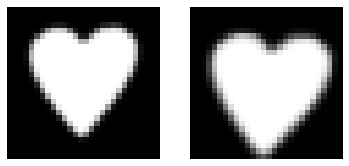

In [32]:
from skimage.transform import resize

suite_shape = (300, 300)
suite_reshape = (28,28)

# Try some transformation
tform = tf.SimilarityTransform(scale=0.9, rotation= -np.deg2rad(4))

fig, ax = plt.subplots(1, 2, figsize = (6, 6))

# Add padding
padding = ((40, 40), (40, 40))
test_im = np.pad(h_images[60,:].reshape(suite_shape), padding, 'constant', constant_values=0)

ax[0].imshow(resize(test_im, suite_reshape), cmap='gray')
ax[0].axis('off')

ax[1].imshow(tf.warp(resize(test_im, suite_reshape), tform), cmap='gray')
ax[1].axis('off')

plt.show()

In [33]:
h_images.shape

(167, 90000)

As for the ranks, we will generate around 7000 samples, 6000 for training and 1000 for testing

In [34]:
def gen_samples_suites(images, image_label, scale_low=0.9, scale_high=1.1,
                rot=np.deg2rad(4), num_samples=334):

    gen = []

    for num in range(images.shape[0]):

        # Add padding
        padding = ((40, 40), (40, 40))
        im = np.pad(images[num, :].reshape(suite_shape), padding, 'constant', constant_values=0)
        
        # Resize 
        im = resize(im, suite_reshape)
        
        gen.append(im.flatten())

        # Generate num_samples samples for each image
        for i in range(num_samples):
           
            tform = tf.SimilarityTransform(scale=uniform(scale_low, scale_high), rotation=uniform(-rot, rot))

            gen.append(tf.warp(im, tform).flatten())

    # Combine images + labels in one array
    gen = np.asarray(gen)
    gen_array = np.empty((gen.shape[0], gen.shape[1]+1))
    gen_array[:,:-1] = gen
    gen_array[:, -1] = np.ones((gen.shape[0],)) * image_label

    return gen_array

In [35]:
h_gen = gen_samples_suites(h_images, 0, num_samples=42)

In [36]:
h_gen.shape

(7181, 785)

##### For C

In [37]:
c_mask = (suites_label_op == 1)
c_images = suites_images[c_mask]

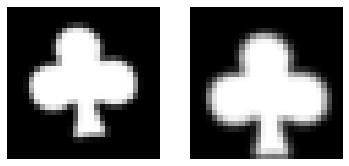

In [38]:
# Try some transformation
tform = tf.SimilarityTransform(scale=0.9, rotation= -np.deg2rad(4))

fig, ax = plt.subplots(1, 2, figsize = (6, 6))

# Add padding
test_im = np.pad(c_images[10,:].reshape(suite_shape), padding, 'constant', constant_values=0)

ax[0].imshow(resize(test_im, suite_reshape), cmap='gray')
ax[0].axis('off')

ax[1].imshow(tf.warp(resize(test_im, suite_reshape), tform), cmap='gray')
ax[1].axis('off')

plt.show()

In [39]:
c_images.shape

(140, 90000)

In [40]:
c_gen = gen_samples_suites(c_images, 1, num_samples=50)

In [41]:
c_gen.shape

(7140, 785)

##### For D

In [42]:
d_mask = (suites_label_op == 2)
d_images = suites_images[d_mask]

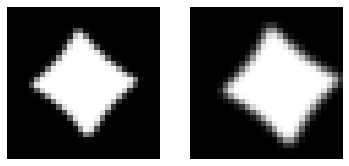

In [43]:
# Try some transformation
tform = tf.SimilarityTransform(scale=0.9, rotation= np.deg2rad(4))

fig, ax = plt.subplots(1, 2, figsize = (6, 6))

test_im = np.pad(d_images[7,:].reshape(suite_shape), padding, 'constant', constant_values=0)

ax[0].imshow(resize(test_im, suite_reshape), cmap='gray')
ax[0].axis('off')

ax[1].imshow(tf.warp(resize(test_im, suite_reshape), tform), cmap='gray')
ax[1].axis('off')

plt.show()

In [44]:
d_images.shape

(146, 90000)

In [45]:
d_gen = gen_samples_suites(d_images, 2, num_samples=48)

In [46]:
d_gen.shape

(7154, 785)

##### For S

In [48]:
s_mask = (suites_label_op == 3)
s_images = suites_images[s_mask]

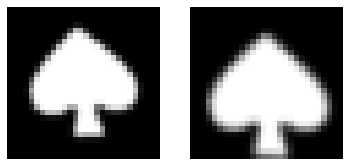

In [56]:
# Try some transformation
tform = tf.SimilarityTransform(scale=0.9, rotation= -np.deg2rad(4))

fig, ax = plt.subplots(1, 2, figsize = (6, 6))

test_im = np.pad(s_images[7,:].reshape(suite_shape), padding, 'constant', constant_values=0)

ax[0].imshow(resize(test_im, suite_reshape), cmap='gray')
ax[0].axis('off')

ax[1].imshow(tf.warp(resize(test_im, suite_reshape), tform), cmap='gray')
ax[1].axis('off')

plt.show()

In [58]:
s_images.shape

(158, 90000)

In [59]:
s_gen = gen_samples_suites(s_images, 2, num_samples=45)

In [60]:
s_gen.shape

(7268, 785)

#### Merge generated data

In [61]:
merged_gen = np.append(h_gen, c_gen, axis=0)
merged_gen = np.append(merged_gen, d_gen, axis=0)
merged_gen = np.append(merged_gen, s_gen, axis=0)
np.random.shuffle(merged_gen)

In [62]:
merged_gen.shape

(28743, 785)

As for the ranks we take about 4000 samples for the test set (1000 for each class) and the rest for the training set.

In [63]:
test_merged = merged_gen[:4000]
train_merged = merged_gen[4000:]

In [64]:
np.save(save_folder+'test_suites.npy', test_merged)
np.save(save_folder+'train_suites.npy', train_merged)

### Classification

We need to split the images and the labels.

In [65]:
train_im = train_merged[:,:-1]
train_labels = train_merged[:,-1].astype(np.int64)

test_im = test_merged[:,:-1]
test_labels = test_merged[:,-1].astype(np.int64)

We train a simple MLP to perform classification

In [66]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # to scale the values of the pixels
scaler.fit(train_im)  

train_images_scaled = scaler.transform(train_im)  # Scale train_images
test_images_scaled = scaler.transform(test_im) # Scale test_images

hidden_units = 100

clf = MLPClassifier(hidden_layer_sizes = (hidden_units,), random_state=42).fit(train_images_scaled, train_labels)

clf.score(test_images_scaled, test_labels)

0.99875